In [1]:
import numpy as np, sys, json, datetime, multiprocessing
import matplotlib.pyplot as plt
import tikzplotlib as tkz
from tqdm.auto import tqdm

from regressors import GaussianProcessRegressor, DoubleGaussianProcessRegressor
from envs import IndependentPricingEnv
from utils import generate_curves, generate_user_ranges, generate_graph

In [2]:
"""
class IndependentPricingEnv:
    
    def __init__(self, n_products, n_actions, actions, demands, user_range, seed=0):
        
        self.n_products = n_products
        self.n_actions = n_actions
        self.demands = demands
        self.actions = actions
        self.user_range = user_range
        
    
    def step(self, action):
        
        assert action.ndim == 1 and action.shape[0] == self.n_products, "error in action"
        sales = np.zeros((self.n_products, 2), dtype=int)
        sales[:, 1] = 1000
        sales[:, 0] = np.round(sales[:, 1] * np.array([self.demands[i, action[i]] for i in range(self.n_products)]))
        return sales


    def compute_optimal_actions(self):
        return np.argmax(np.multiply(self.demands, self.actions), axis=1), np.max(np.multiply(self.demands, self.actions), axis=1)
"""

'\nclass IndependentPricingEnv:\n    \n    def __init__(self, n_products, n_actions, actions, demands, user_range, seed=0):\n        \n        self.n_products = n_products\n        self.n_actions = n_actions\n        self.demands = demands\n        self.actions = actions\n        self.user_range = user_range\n        \n    \n    def step(self, action):\n        \n        assert action.ndim == 1 and action.shape[0] == self.n_products, "error in action"\n        sales = np.zeros((self.n_products, 2), dtype=int)\n        sales[:, 1] = 1000\n        sales[:, 0] = np.round(sales[:, 1] * np.array([self.demands[i, action[i]] for i in range(self.n_products)]))\n        return sales\n\n\n    def compute_optimal_actions(self):\n        return np.argmax(np.multiply(self.demands, self.actions), axis=1), np.max(np.multiply(self.demands, self.actions), axis=1)\n'

In [3]:
class PricingAgentComplementary: 

    
    def __init__(self, num_products, actions, costs, kernel_L, sigma_process, horizon, graph_dict=None, verbose=True):

        self.num_products = num_products
        self.num_actions = len(actions)
        
        self.actions = actions
        self.costs = costs
        
        self.kernel_L = kernel_L
        self.sigma_process = sigma_process
        
        self.horizon = horizon
        self.beta = 4 * np.log(self.horizon)
        
        self.interactions_count = 0

        self.total_sales = np.zeros(self.num_products)

        actions0, actions1 = np.meshgrid(self.actions, self.actions)
        self.byvariate_actions = np.hstack((actions0.ravel().reshape(-1, 1), actions1.ravel().reshape(-1, 1)))
        actions0, actions1 = np.meshgrid(np.linspace(0, self.num_actions-1, self.num_actions, dtype=int), 
                                         np.linspace(0, self.num_actions-1, self.num_actions, dtype=int))
        self.byvariate_actions_map = np.hstack((actions0.ravel().reshape(-1, 1), actions1.ravel().reshape(-1, 1)))

        self.verbose = verbose
        
        if graph_dict is None:
            self.known_relations = False
            self.interactions_dataset = -1 * np.ones((num_products, horizon, 2))
        else:
            self.known_relations = True
            self.used_graph_dict = graph_dict
            self._create_regressors()

        if self.verbose:
            print("num products and actions", self.num_products, self.num_actions)
            print("actions", self.actions)
            print("costs", self.costs)
            print("horizon and beta", self.horizon, self.beta)
            print("total sales", self.total_sales)
            print("byvariate_actions", self.byvariate_actions)
            print("byvariate_actions_map", self.byvariate_actions_map)
            print("used_graph_dict", self.used_graph_dict)

    
    def pull(self):

        if self.verbose:
            print("Executing pull(). Interaction count before this: " + str(self.interactions_count))
        
        if self.interactions_count == 0:
            
            self.last_actions_vect = np.zeros(self.num_products, dtype=int)
        
        else:

            self.last_actions_vect = -1 * np.ones(self.num_products, dtype=int)
            
            if self.known_relations:

                if self.verbose:
                    print("Executing pull(). self.used_graph_dict.keys(): " + str(self.used_graph_dict.keys()))
                
                for key in list(self.used_graph_dict.keys()):

                    if self.verbose:
                        print("Executing pull(). running for cicle for key: " + str(key))
                    
                    if len(self.used_graph_dict[key]) == 0: 

                        if self.verbose:
                            print("Executing pull(). We have " + str(len(self.used_graph_dict[key])) + "trained products: we use single regressor")
                        
                        mu, sigma = self.regressors[key].compute(self.actions.reshape(self.num_actions, 1))
                        self.last_actions_vect[key] = np.argmax(self.actions * (mu + self.beta * sigma))
                        
                    else: 
                        
                        trainee_lst = self.used_graph_dict[key]
                        aux1 = np.array([self.total_sales[trainee_lst[i]] for i in range(len(trainee_lst))])
                        aux2 = np.array([self.costs[trainee_lst[i]] for i in range(len(trainee_lst))])
                        trainee_w = np.sum(aux1 * aux2)
                        trainer_w = self.total_sales[key] * self.costs[key]

                        if self.verbose:
                            print("Executing pull(). We have " + str(len(self.used_graph_dict[key])) + "trained products: we use double regressor")
                            print("Executing pull(). trainee_lst: " + str(trainee_lst))
                            print("Executing pull(). aux1 (sales): " + str(aux1))
                            print("Executing pull(). aux2 (costs): " + str(aux2))
                            print("Executing pull(). trainee_w: " + str(trainee_w))
                            print("Executing pull(). trainer_w: " + str(trainer_w))
                        
                        mu_y1, mu_y2, sigma = self.regressors[key].compute(self.byvariate_actions)
                        idx = np.argmax(
                            self.byvariate_actions[:, 0] * trainer_w * (mu_y1 + self.beta * sigma) + 
                            self.byvariate_actions[:, 1] * trainee_w * (mu_y2 + self.beta * sigma)
                        )

                        if self.verbose:
                            print("Executing pull(). mu_y1: " + str(mu_y1))
                            print("Executing pull(). mu_y2: " + str(mu_y2))
                            print("Executing pull(). sigma: " + str(sigma))
                            print("Executing pull(). idx: " + str(idx))
                            
                        self.last_actions_vect[key] = self.byvariate_actions_map[idx, 0]
                        for i in range(len(trainee_lst)):
                            self.last_actions_vect[trainee_lst[i]] = self.byvariate_actions_map[idx, 1]
            
            else:
                
                raise NotImplementedError("unknown graph scenario not implemented")     

        if self.verbose:
            print("Executing pull(). Playing: " + str(self.last_actions_vect))
        
        return self.last_actions_vect
            
    
    def update(self, sales, impressions, interactions=None):
        
        assert sales.shape == (self.num_products, ) and impressions.shape == (self.num_products, ), "update(): error in input"
        
        self.total_sales = self.total_sales + sales
        
        rewards = sales / impressions
        
        if self.known_relations:
            
            for key in list(self.used_graph_dict.keys()):
                if len(self.used_graph_dict[key]) == 0: 
                    self.regressors[key].update_data(self.actions[self.last_actions_vect[key]], rewards[key])
                else: 
                    trainee_lst = self.used_graph_dict[key]
                    for i in range(len(trainee_lst)):
                        if i < len(trainee_lst) - 1:
                            assert self.last_actions_vect[trainee_lst[i]] == self.last_actions_vect[trainee_lst[i+1]
                                ], "update(): error, actions must be the same for all trainee"
                    trainee_lst = self.used_graph_dict[key]
                    rw = np.array([rewards[trainee_lst[i]] for i in range(len(trainee_lst))])
                    aux1 = np.array([sales[trainee_lst[i]] for i in range(len(trainee_lst))])
                    aux2 = np.array([self.costs[trainee_lst[i]] for i in range(len(trainee_lst))])
                    aux1 = np.nan_to_num(aux1, nan=1.0)
                    aux1 = np.maximum(aux1, 1)
                    aux = aux1 * aux2
                    avg_reward = (rw.reshape(1, len(trainee_lst)) @ aux.reshape(len(trainee_lst), 1)) / np.sum(aux)

                    if self.verbose:
                        print("Executing update(). aux1 (sales): " + str(aux1))
                        print("Executing update(). aux2 (costs): " + str(aux2))
                        print("Executing update(). avg_reward: " + str(avg_reward))
                    
                    self.regressors[key].update_data(
                        [self.actions[self.last_actions_vect[key]], self.actions[self.last_actions_vect[self.used_graph_dict[key][0]]]],
                        rewards[key], avg_reward
                    )
        
        else:
            
            raise NotImplementedError("unknown graph scenario not implemented")
            self._update_graph_data()

        self.interactions_count += 1

    
    def _create_regressors(self):

        self.regressors = {}
        
        for key in list(self.used_graph_dict.keys()):
            if len(self.used_graph_dict[key]) == 0: 
                self.regressors[key] = GaussianProcessRegressor(self.kernel_L, self.sigma_process, 1)
            else: 
                self.regressors[key] = DoubleGaussianProcessRegressor(self.kernel_L, self.sigma_process, 2)
        
        if self.verbose:
            print("Created regressors: " + str(self.regressors) + " from dict: " + str(self.used_graph_dict))
    
    def _update_graph_data(self):

        raise NotImplementedError("unknown graph scenario not implemented")

In [4]:
num_actions = 10
num_products = 3
num_clusters = 1
horizon = 1000
min_users = 100
max_users = 200
user_ranges_overall = [min_users, max_users]
sigma_process = 1 / (2 * np.sqrt(min_users))
actions = np.linspace(0.1, 1.0, num_actions)
costs = np.ones(num_products) # np.random.uniform(1, 2, num_products)
kernel_L = 10

algs = ["Indep"]

num_trials = 1

results_dict = []

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

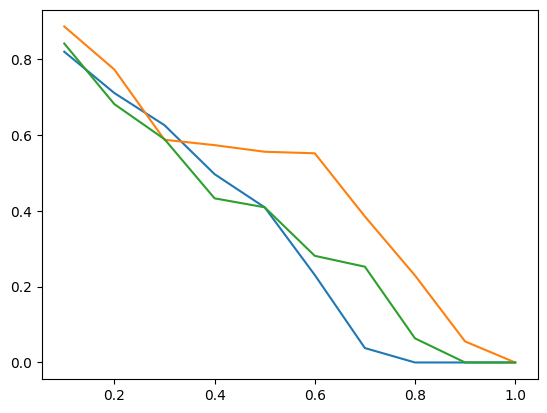

In [11]:
for trial_id in range(num_trials):
    
    results_dict.append({key : {"res" : np.zeros((horizon, num_products)), "act" : np.zeros((horizon, num_products), dtype=int)}
                         for key in algs})
    np.random.seed(trial_id)

    demands = generate_curves(num_products, num_actions=num_actions)

    plt.plot(np.linspace(0.1,1,10),demands.T)
    
    # print("demands: " + str(demands))
    
    user_ranges = generate_user_ranges(num_products, user_ranges_overall[0], user_ranges_overall[1])
    
    # graph_dict = {i : [] for i in range(num_products)}
    graph_dict = generate_graph(num_products, num_clusters)

    for key in graph_dict.keys():
        if len(graph_dict[key]) > 1:
            for i in range(1, len(graph_dict[key])):
                demands[graph_dict[key][i], :] = demands[graph_dict[key][0], :]

    env = IndependentPricingEnv(num_products, num_actions, np.repeat(actions.reshape(1, -1), num_products, axis=0), 
                                demands, user_ranges, seed=trial_id)
    optimal_actions, optimal_values = env.compute_optimal_actions()
    

    # print("demands transformed: " + str(demands))
    
    agent = PricingAgentComplementary(num_products, actions, costs, kernel_L, sigma_process, 
                                      horizon, graph_dict=graph_dict, verbose=False)

    for t in tqdm(range(horizon)):
        
        results_dict[trial_id]["Indep"]["act"][t, :] = agent.pull()
        
        res = env.step(results_dict[trial_id]["Indep"]["act"][t, :])
        # print(res)
        agent.update(res[:, 0], res[:, 1])
        
        for i in range(num_products):
            
            results_dict[trial_id]["Indep"]["res"][t, i] = res[i, 1] * optimal_values[i] - res[i, 0
                ] * actions[results_dict[trial_id]["Indep"]["act"][t, i]]

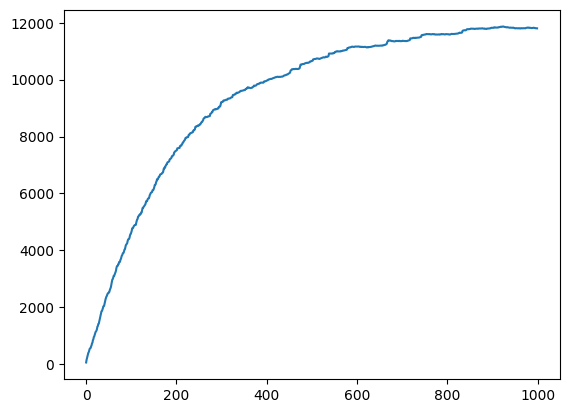

In [6]:
plt.figure()
x_plt = np.linspace(0, horizon-1, horizon, dtype=int)

for alg in algs:
    
    aux = np.zeros((num_trials, horizon))
    for i in range(num_trials):
        aux[i, :] = np.array(results_dict[i][alg]["res"]).sum(axis=1)
        
    results_alg = np.cumsum(aux, axis=1)
    results_mean = np.mean(results_alg, axis=0)
    results_std = 1.96 * results_alg.std(axis=0) / np.sqrt(num_trials)

    plt.plot(x_plt, results_mean[x_plt], label=alg)
    plt.fill_between(x_plt, results_mean[x_plt] - results_std[x_plt], results_mean[x_plt] + results_std[x_plt], alpha=0.3)

In [7]:
results_dict[trial_id]["Indep"]["act"]

array([[0, 0, 0],
       [9, 9, 9],
       [9, 9, 5],
       ...,
       [4, 4, 4],
       [4, 4, 4],
       [4, 4, 4]])

In [8]:
optimal_actions

array([4, 4, 4])